In [3]:
import os 
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from skimage.transform import resize, rescale
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv2

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense ,Conv2D,MaxPooling2D ,Dropout
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
import tensorflow as tf

print(tf.__version__)

2025-03-06 00:24:54.730815: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-06 00:24:54.730978: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-06 00:24:54.865506: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0


In [4]:
def get_all_sst_files(base_directory, filename):
        sst_files = []
        for dirs, _, files in os.walk(base_directory):
            # print(f"Current directory: {root}")  # 디버깅을 위한 현재 디렉토리 출력
            for file in files:
                if file.endswith(filename):
                    sst_files.append(os.path.join(dirs, file))
                    # print(f"Found file: {file}")  # 디버깅을 위한 파일명 출력
        return sst_files

In [7]:
# Mcal file numpy 변환
def read_sst_file(file_path):
    result = True
    msg = ""
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
            data = []
            for line in lines:
                values = list(map(float, line.split()))
                data.append(values)
            col, row = int(data[0][0]), int(data[0][1])
            start_x, start_y = data[0][2], data[0][3]
            pitch=int(data[0][4])
            # col = 54, row = 52
            data.pop(0)
            for i in range(len(data)):
                data[i][0]-=start_x
                data[i][1]-=start_y
                data[i][0]-=(i%col)*pitch
                data[i][1]+=(i//col)*pitch
                data[i][0]=round(data[i][0], 4)*1000
                data[i][1]=round(data[i][1], 4)*1000  
            data=np.array(data)
            x_offset=data[:,0]
            y_offset=data[:,1]
            x_offset=x_offset.reshape(row, col)
            y_offset=y_offset.reshape(row, col)
            return np.stack([x_offset, y_offset], axis=-1)

    except Exception as ex:
        result = False
        msg = f"파일을 읽는 도중 에러가 발생했습니다: {ex}"
    finally:
        if result is False:
            print(msg)

In [5]:
mcal_l_dir=get_all_sst_files('/kaggle/input/mcaldatasets', 'MCal.sst')
# mcal_xl_dir=get_all_sst_files(r'C:\work\M-CAL (XL)', 'MCal.sst')
len(mcal_l_dir)

1827

In [8]:
from collections import Counter
temp_list=list()
new_mcal_list=list()
new_mcal_list_shape=list()
min_num, max_num = 0, 0
for directory in mcal_l_dir:
    image=read_sst_file(directory)
    temp_list.append(image.shape)
    if 51<=image.shape[0]<=54 and 51<=image.shape[1]<=54:
        new_mcal_list.append(directory)
        new_mcal_list_shape.append(image.shape)
        min_num=min(np.min(image), min_num)
        max_num=max(np.max(image), max_num)
min_num, max_num, Counter(temp_list), Counter(new_mcal_list_shape)

(-372.0,
 196.0,
 Counter({(52, 54, 2): 1240,
          (52, 53, 2): 399,
          (52, 49, 2): 45,
          (51, 54, 2): 43,
          (101, 103, 2): 24,
          (101, 105, 2): 22,
          (101, 104, 2): 11,
          (36, 36, 2): 6,
          (52, 52, 2): 6,
          (51, 53, 2): 6,
          (47, 54, 2): 6,
          (99, 103, 2): 4,
          (52, 43, 2): 2,
          (52, 48, 2): 2,
          (51, 49, 2): 2,
          (35, 36, 2): 2,
          (67, 69, 2): 1,
          (51, 48, 2): 1,
          (99, 105, 2): 1,
          (35, 35, 2): 1,
          (51, 52, 2): 1,
          (50, 54, 2): 1,
          (52, 42, 2): 1}),
 Counter({(52, 54, 2): 1240,
          (52, 53, 2): 399,
          (51, 54, 2): 43,
          (52, 52, 2): 6,
          (51, 53, 2): 6,
          (51, 52, 2): 1}))

In [9]:
len(new_mcal_list)

1695

In [10]:
from sklearn.model_selection import train_test_split

train_dir, test_dir = train_test_split(np.array(new_mcal_list), test_size=0.02, random_state=2024)
train_dir, val_dir = train_test_split(train_dir, test_size=0.1, random_state=2024)

In [11]:
len(train_dir), len(val_dir), len(test_dir)

(1494, 167, 34)

In [12]:
from tensorflow.keras.utils import Sequence
import sklearn 
import cv2

# 배치 크기와 이미지 크기를 전역 변수로 선언 
BATCH_SIZE = 16
IMAGE_SIZE = (51, 51, 2)

# 입력 인자 image_filenames, labels는 모두 numpy array로 들어옴. 
class Mcal_Large_Dataset(Sequence):
    
    # 객체 생성 인자로 들어온 값을 객체 내부 변수로 할당.
    def __init__(self, image_filenames,batch_size=BATCH_SIZE, augmentor=None, shuffle=False, pre_func=None):
        '''
        파라미터 설명
        image_filenames: opencv로 image를 로드할 파일의 절대 경로들(list)
        batch_size: __getitem__(self, index) 호출 시 마다 가져올 데이터 batch 건수
        augmentor: albumentations 객체
        shuffle: 학습 데이터의 경우 epoch 종료시마다 데이터를 섞을지 여부
        '''
        # 객체 생성 인자로 들어온 값을 객체 내부 변수로 할당. 
        self.image_filenames = image_filenames
        self.batch_size = batch_size
        self.augmentor = augmentor
        self.pre_func = pre_func
        self.shuffle = shuffle
        # train data의 경우 
        if self.shuffle:
            # 객체 생성시에 한번 데이터를 섞음. 
            self.on_epoch_end()
            
    # Sequence를 상속받은 Dataset은 batch_size 단위로 입력된 데이터를 처리함. 
    # __len__()은 전체 데이터 건수가 주어졌을 때 batch_size단위로 몇번 데이터를 반환하는지 나타남
    
    def __len__(self):
        # batch_size단위로 데이터를 몇번 가져와야하는지 계산하기 위해 전체 데이터 건수를 batch_size로 나누되, 정수로 정확히 나눠지지 않을 경우 1회를 더한다.
        return int(np.ceil(len(self.image_filenames)/self.batch_size))
        
    def __getitem__(self, index):
    # batch_size 단위로 image_array, label_array 데이터를 가져와서 변환한 뒤 다시 반환함
    # 인자로 몇번째 batch 인지를 나타내는 index를 입력하면 해당 순서에 해당하는 batch_size 만큼의 데이타를 가공하여 반환
    # batch_size 갯수만큼 변환된 image_array와 label_array 반환. 
    
        # index는 몇번째 batch인지를 나타냄. 
        # batch_size만큼 순차적으로 데이터를 가져오려면 array에서 index*self.batch_size:(index+1)*self.batch_size 만큼의 연속 데이터를 가져오면 됨
        image_name_batch = self.image_filenames[index*self.batch_size:(index+1)*self.batch_size]
        
        # 만일 객체 생성 인자로 albumentation으로 만든 augmentor가 주어진다면 아래와 같이 augmentor를 이용하여 image 변환
        # albumentations은 개별 image만 변환할 수 있으므로 batch_size만큼 할당된 image_name_batch를 한 건씩 iteration하면서 변환 수행. 
        # image_batch 배열은 float32 로 설정. 
        high_image_batch = np.zeros((image_name_batch.shape[0], 51, 51, 2))
        low_image_batch = np.zeros((image_name_batch.shape[0], 51, 51, 2))
        
        # batch_size에 담긴 건수만큼 iteration 하면서 opencv image load -> image augmentation 변환(augmentor가 not None일 경우)-> image_batch에 담음.
        for image_index in range(image_name_batch.shape[0]):
            image = read_sst_file(image_name_batch[image_index])
            hr_image=image[0:51,0:51,:]
            lr_image=hr_image[1::3,1::3,:]
            # lr_image=cv2.resize(lr_image, (51, 51))
            lr_image=np.repeat(np.repeat(lr_image, 3, axis=0), 3, axis=1)
            if self.augmentor is not None:
                image = self.augmentor(image=image)['image']
                
            # 만일 preprocessing_input이 pre_func인자로 들어오면 이를 이용하여 scaling 적용. 
            if self.pre_func is not None:
                combined_min = min(hr_image.min(), lr_image.min())
                combined_max = max(hr_image.max(), lr_image.max())
                
                # 두 이미지에 공통된 최소, 최대값을 사용해 동일한 방식으로 스케일링
                hr_image = self.pre_func(hr_image, combined_min, combined_max)
                lr_image = self.pre_func(lr_image, combined_min, combined_max)
        
            low_image_batch[image_index]  = lr_image
            high_image_batch[image_index] = hr_image
       
        return low_image_batch, high_image_batch
            
            
    # epoch가 한번 수행이 완료 될 때마다 모델의 fit()에서 호출됨. 
    def on_epoch_end(self):
        if(self.shuffle):
            self.image_filenames = sklearn.utils.shuffle(self.image_filenames)
        else:
            pass

In [13]:
# min_num = -372
# max_num = 196
# def pre_func(data):
#     return (data - min_num) / (max_num - min_num)

def minmax_scaling(image, min_val, max_val):
    scaled_image = (image - min_val) / (max_val - min_val)
    return scaled_image


In [14]:
train_ds=Mcal_Large_Dataset(train_dir, batch_size=4, augmentor=None, shuffle=True, pre_func=minmax_scaling)
valid_ds=Mcal_Large_Dataset(val_dir, batch_size=4, augmentor=None, shuffle=False, pre_func=minmax_scaling)
test_ds=Mcal_Large_Dataset(test_dir, batch_size=4, augmentor=None, shuffle=False, pre_func=minmax_scaling)

In [15]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D, Add
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler

def Create_VDSR(input_shape=(51, 51, 2), verbose=False):
    inputs = Input(shape=input_shape)
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(inputs)
    
    for _ in range(6):  # 20개의 레이어 중 첫 레이어와 마지막 레이어를 제외한 18개의 레이어
        x = Conv2D(filters=32, kernel_size=(3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    # 마지막 레이어: 활성화 함수 없음
    residual = Conv2D(filters=input_shape[2], kernel_size=(3, 3), padding='same', activation='linear')(x)
    
    # 입력과 출력의 더하기 연산 (Residual Learning)
    outputs = Add()([inputs, residual])
    
    
    model = Model(inputs=inputs, outputs=outputs)
    if verbose:
        model.summary()
    return model

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 51, 51, 2) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 51, 51,    │      1,216 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 51, 51,    │     18,464 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 51, 51,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 51, 51,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 51, 51,    │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 51, 51,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 51, 51,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 51, 51,    │      9,248 │ activation_1[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 51, 51,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 51, 51,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 51, 51,    │      9,248 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 51, 51,    │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 51, 51,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 51, 51,    │      9,248 │ activation_3[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 51, 51,    │        128 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 51, 51,    │          0 │ batch_normalizat

 Total params: 67,266 (262.76 KB)

 Trainable params: 66,882 (261.26 KB)

 Non-trainable params: 384 (1.50 KB)

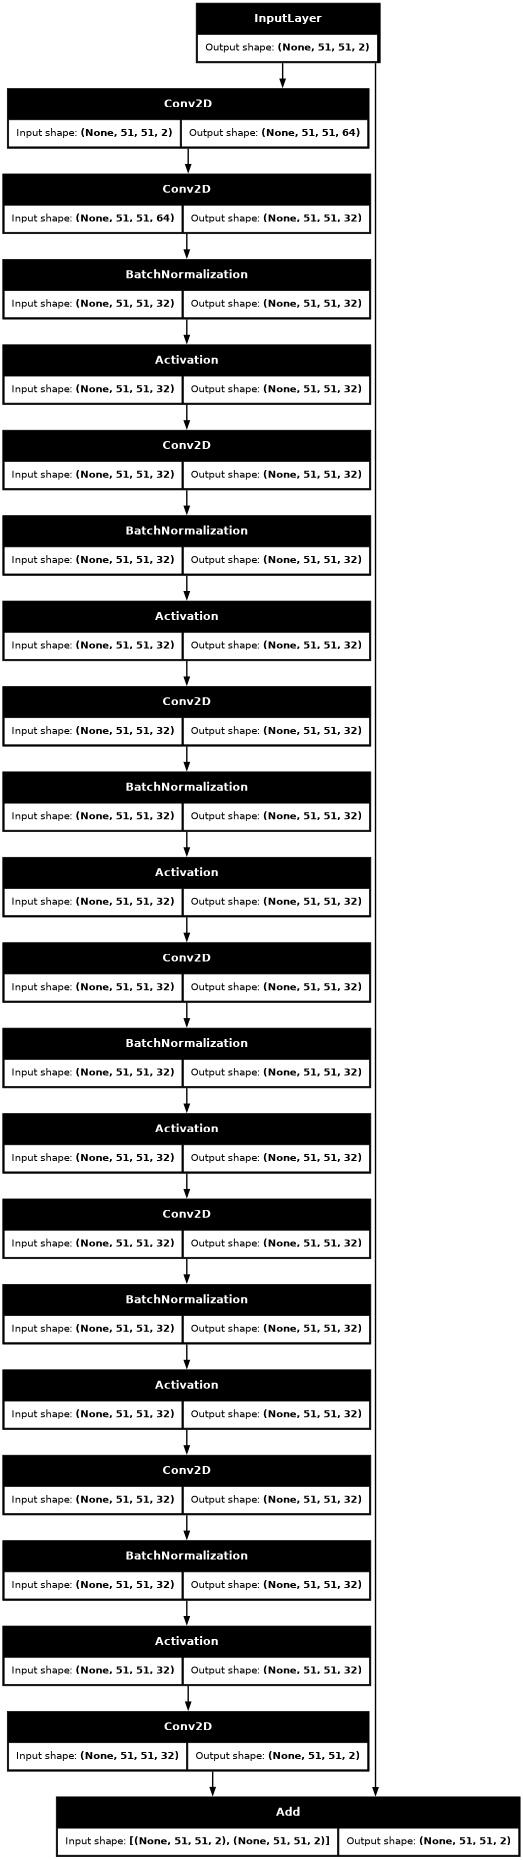

In [16]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file ='model.png',show_shapes=True, dpi=50)

In [17]:
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler


model = Create_VDSR(verbose=True)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# 3번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.4로 줄임.  
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, mode='min', verbose=1)
# 5번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

history=model.fit(train_ds, epochs = 30, validation_data=valid_ds, callbacks=[rlr_cb, ely_cb])

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 51, 51, 2) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 51, 51,    │      1,216 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 51, 51,    │     18,464 │ conv2d_8[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 51, 51,    │        128 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 51, 51,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 51, 51,    │      9,248 │ activation_6[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 51, 51,    │        128 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 51, 51,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 51, 51,    │      9,248 │ activation_7[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 51, 51,    │        128 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 51, 51,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 51, 51,    │      9,248 │ activation_8[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 51, 51,    │        128 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 51, 51,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 51, 51,    │      9,248 │ activation_9[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 51, 51,    │        128 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 51, 51,    │          0 │ batch_normalizat

 Total params: 67,266 (262.76 KB)

 Trainable params: 66,882 (261.26 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  5/374 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - loss: 0.3539

I0000 00:00:1741221035.104702     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


374/374 ━━━━━━━━━━━━━━━━━━━━ 28s 53ms/step - loss: 0.0269 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 2/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - loss: 8.9473e-04 - val_loss: 6.9882e-04 - learning_rate: 0.0010
Epoch 3/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - loss: 4.8655e-04 - val_loss: 4.7705e-04 - learning_rate: 0.0010
Epoch 4/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - loss: 3.8531e-04 - val_loss: 3.4131e-04 - learning_rate: 0.0010
Epoch 5/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - loss: 3.0837e-04 - val_loss: 3.7291e-04 - learning_rate: 0.0010
Epoch 6/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - loss: 2.9699e-04 - val_loss: 3.0876e-04 - learning_rate: 0.0010
Epoch 7/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - loss: 2.5382e-04 - val_loss: 2.6996e-04 - learning_rate: 0.0010
Epoch 8/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - loss: 2.3589e-04 - val_loss: 2.3939e-04 - learning_rate: 0.0010
Epoch 9/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - los

In [18]:
model.save('/kaggle/working/vdsr_model.h5')
from tensorflow.keras.models import load_model
load_model = load_model('/kaggle/working/vdsr_model.h5')

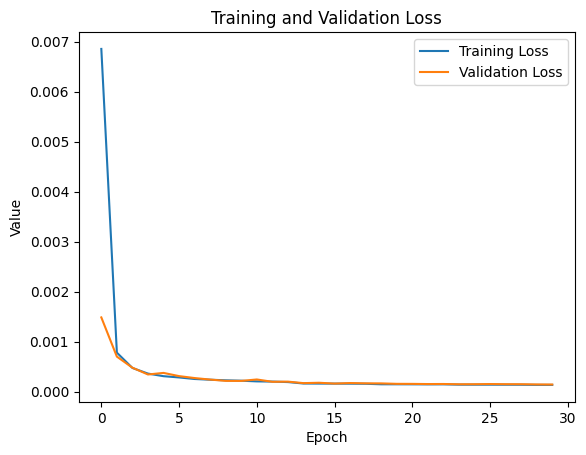

In [19]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.show()

In [ ]:
predicted=[]
original_hr = []
for batch_num in range(len(test_ds)):
    for num in range(test_ds[batch_num][0].shape[0]):
        predictions = test_ds[batch_num][0][num]
        predictions = model.predict(np.expand_dims(predictions, axis=0))
        predictions = np.squeeze(predictions)
        predicted.append((predictions))
        original_hr_data=test_ds[batch_num][1][num]
        original_hr.append((original_hr_data))

(array([  12.,   52.,  187.,  274.,  467.,  916., 1272., 1029.,  808.,
         185.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

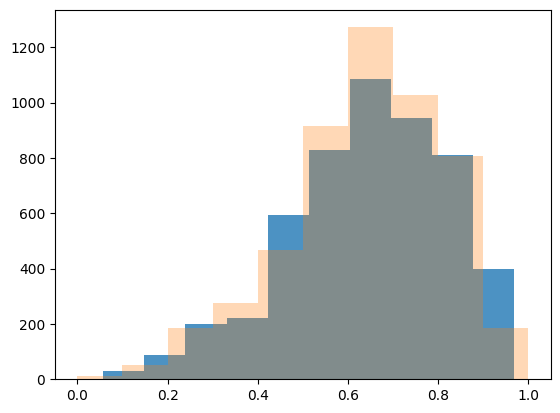

In [21]:
plt.hist(predicted[3].flatten(), bins=10, alpha=0.8)
plt.hist(original_hr[3].flatten(), bins=10, alpha=0.3)
# predictions
# original_hr_data

In [22]:
import numpy as np
import tensorflow as tf
from skimage.metrics import structural_similarity as ssim

# PSNR 함수 정의
def PSNR(original, predicted, max_value=255):
    # MSE 계산
    mse = np.mean((original - predicted) ** 2)
    if mse == 0:
        return float('inf')  # 두 이미지가 완전히 동일하면 무한대
    return 10 * np.log10((max_value ** 2) / mse)

psnr_list=[]
ssim_list=[]

# 각 이미지를 스케일링하고 PSNR, SSIM 계산
for i in range(len(predicted)):
    high_res_tensor = tf.convert_to_tensor(original_hr[i], dtype=tf.float32)
    predicted_tensor = tf.convert_to_tensor(predicted[i], dtype=tf.float32)

    # min_num과 max_num 정의
    min_num = read_sst_file(test_dir[i]).min()
    max_num = read_sst_file(test_dir[i]).max()
    # 스케일링 복원
    original_high_res_tensor = high_res_tensor * (max_num - min_num) + min_num
    original_high_predicted_tensor = predicted_tensor * (max_num - min_num) + min_num

    # NumPy 배열로 변환
    original_high_res_tensor_np = original_high_res_tensor.numpy()
    original_high_predicted_tensor_np = original_high_predicted_tensor.numpy()

    # PSNR 계산
    psnr_value = PSNR(original_high_res_tensor_np, original_high_predicted_tensor_np, max_value=max_num - min_num)
    ssim_value = tf.image.ssim(tf.cast(original_high_res_tensor_np, tf.float32), tf.cast(original_high_predicted_tensor_np, tf.float32), max_val=max_num - min_num)

    print(f"{str(i+1).zfill(3)} PSNR : {np.round(psnr_value, 3):.3f}, SSIM : {ssim_value.numpy():.3f}")

    psnr_list.append(psnr_value)
    ssim_list.append(ssim_value)

print(f"AVG PSNR : {sum(psnr_list)/34:.3f}, SSIM : {sum(ssim_list)/34:.3f}")

001 PSNR : 37.509, SSIM : 0.940
002 PSNR : 42.007, SSIM : 0.977
003 PSNR : 41.158, SSIM : 0.973
004 PSNR : 30.738, SSIM : 0.855
005 PSNR : 38.313, SSIM : 0.953
006 PSNR : 36.331, SSIM : 0.927
007 PSNR : 37.832, SSIM : 0.954
008 PSNR : 36.752, SSIM : 0.939
009 PSNR : 35.000, SSIM : 0.876
010 PSNR : 37.647, SSIM : 0.912
011 PSNR : 40.027, SSIM : 0.953
012 PSNR : 44.016, SSIM : 0.979
013 PSNR : 49.203, SSIM : 0.994
014 PSNR : 34.685, SSIM : 0.909
015 PSNR : 40.373, SSIM : 0.958
016 PSNR : 43.427, SSIM : 0.979
017 PSNR : 33.919, SSIM : 0.838
018 PSNR : 38.406, SSIM : 0.938
019 PSNR : 41.880, SSIM : 0.969
020 PSNR : 36.102, SSIM : 0.920
021 PSNR : 40.994, SSIM : 0.956
022 PSNR : 38.748, SSIM : 0.957
023 PSNR : 42.259, SSIM : 0.970
024 PSNR : 48.035, SSIM : 0.993
025 PSNR : 36.811, SSIM : 0.962
026 PSNR : 44.841, SSIM : 0.984
027 PSNR : 41.160, SSIM : 0.966
028 PSNR : 43.504, SSIM : 0.974
029 PSNR : 44.520, SSIM : 0.983
030 PSNR : 37.505, SSIM : 0.905
031 PSNR : 41.623, SSIM : 0.966
032 PSNR

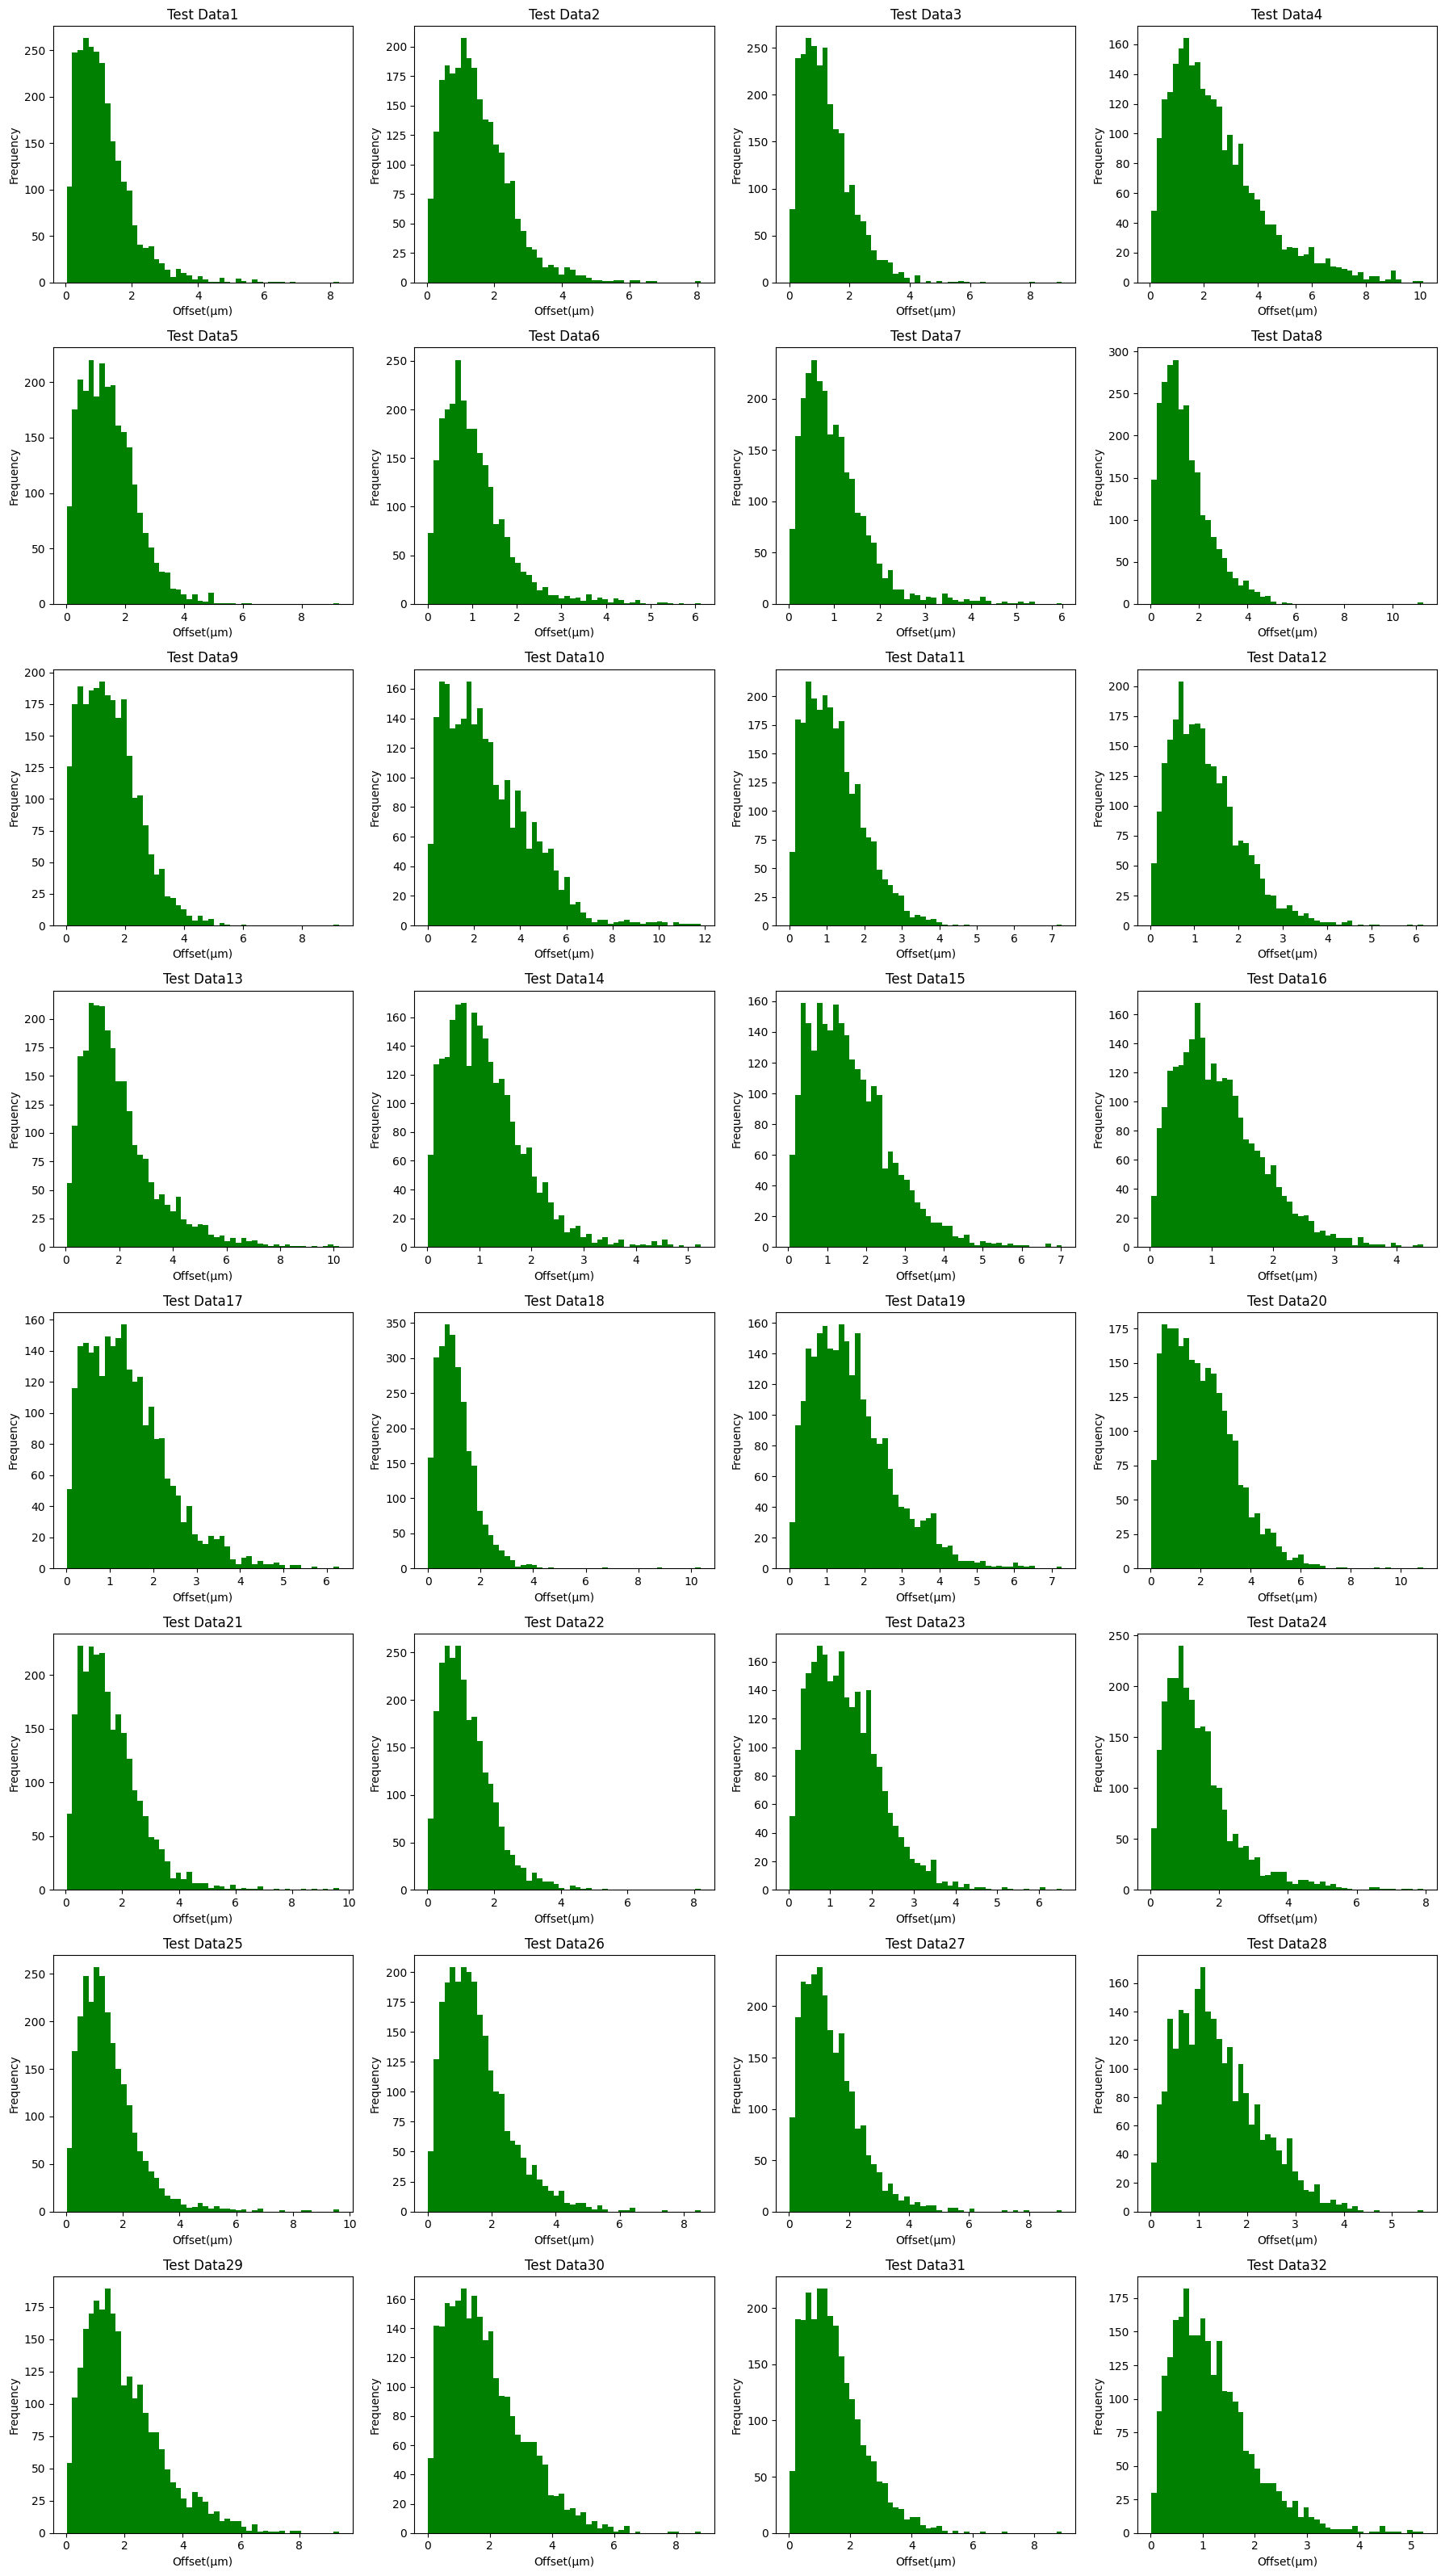

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axs = plt.subplots(8, 4, figsize=(18, 32)) 
for i in range(32):
    high_res_tensor = tf.convert_to_tensor(original_hr[i], dtype=tf.float32)
    predicted_tensor = tf.convert_to_tensor(predicted[i], dtype=tf.float32)
    
    # org_test_hr=high_res_tensor* (max_num - min_num) + min_num
    # org_predicted_image=predicted_tensor* (max_num - min_num) + min_num

     # min_num과 max_num 정의
    min_num = read_sst_file(test_dir[i]).min()
    max_num = read_sst_file(test_dir[i]).max()
    # 스케일링 복원
    org_test_hr = high_res_tensor * (max_num - min_num) + min_num
    org_predicted_image = predicted_tensor * (max_num - min_num) + min_num

    axs[i//4][i%4].set_title(f'Test Data{i+1}')
    axs[i//4][i%4].set_xlabel('Offset(µm)')
    axs[i//4][i%4].set_ylabel('Frequency')
    axs[i//4][i%4].hist(np.sqrt((org_test_hr[:,:,0] - org_predicted_image[:,:,0])**2+(org_test_hr[:,:,1] - org_predicted_image[:,:,1])**2).flatten(),bins=50, color='green') 

plt.tight_layout()

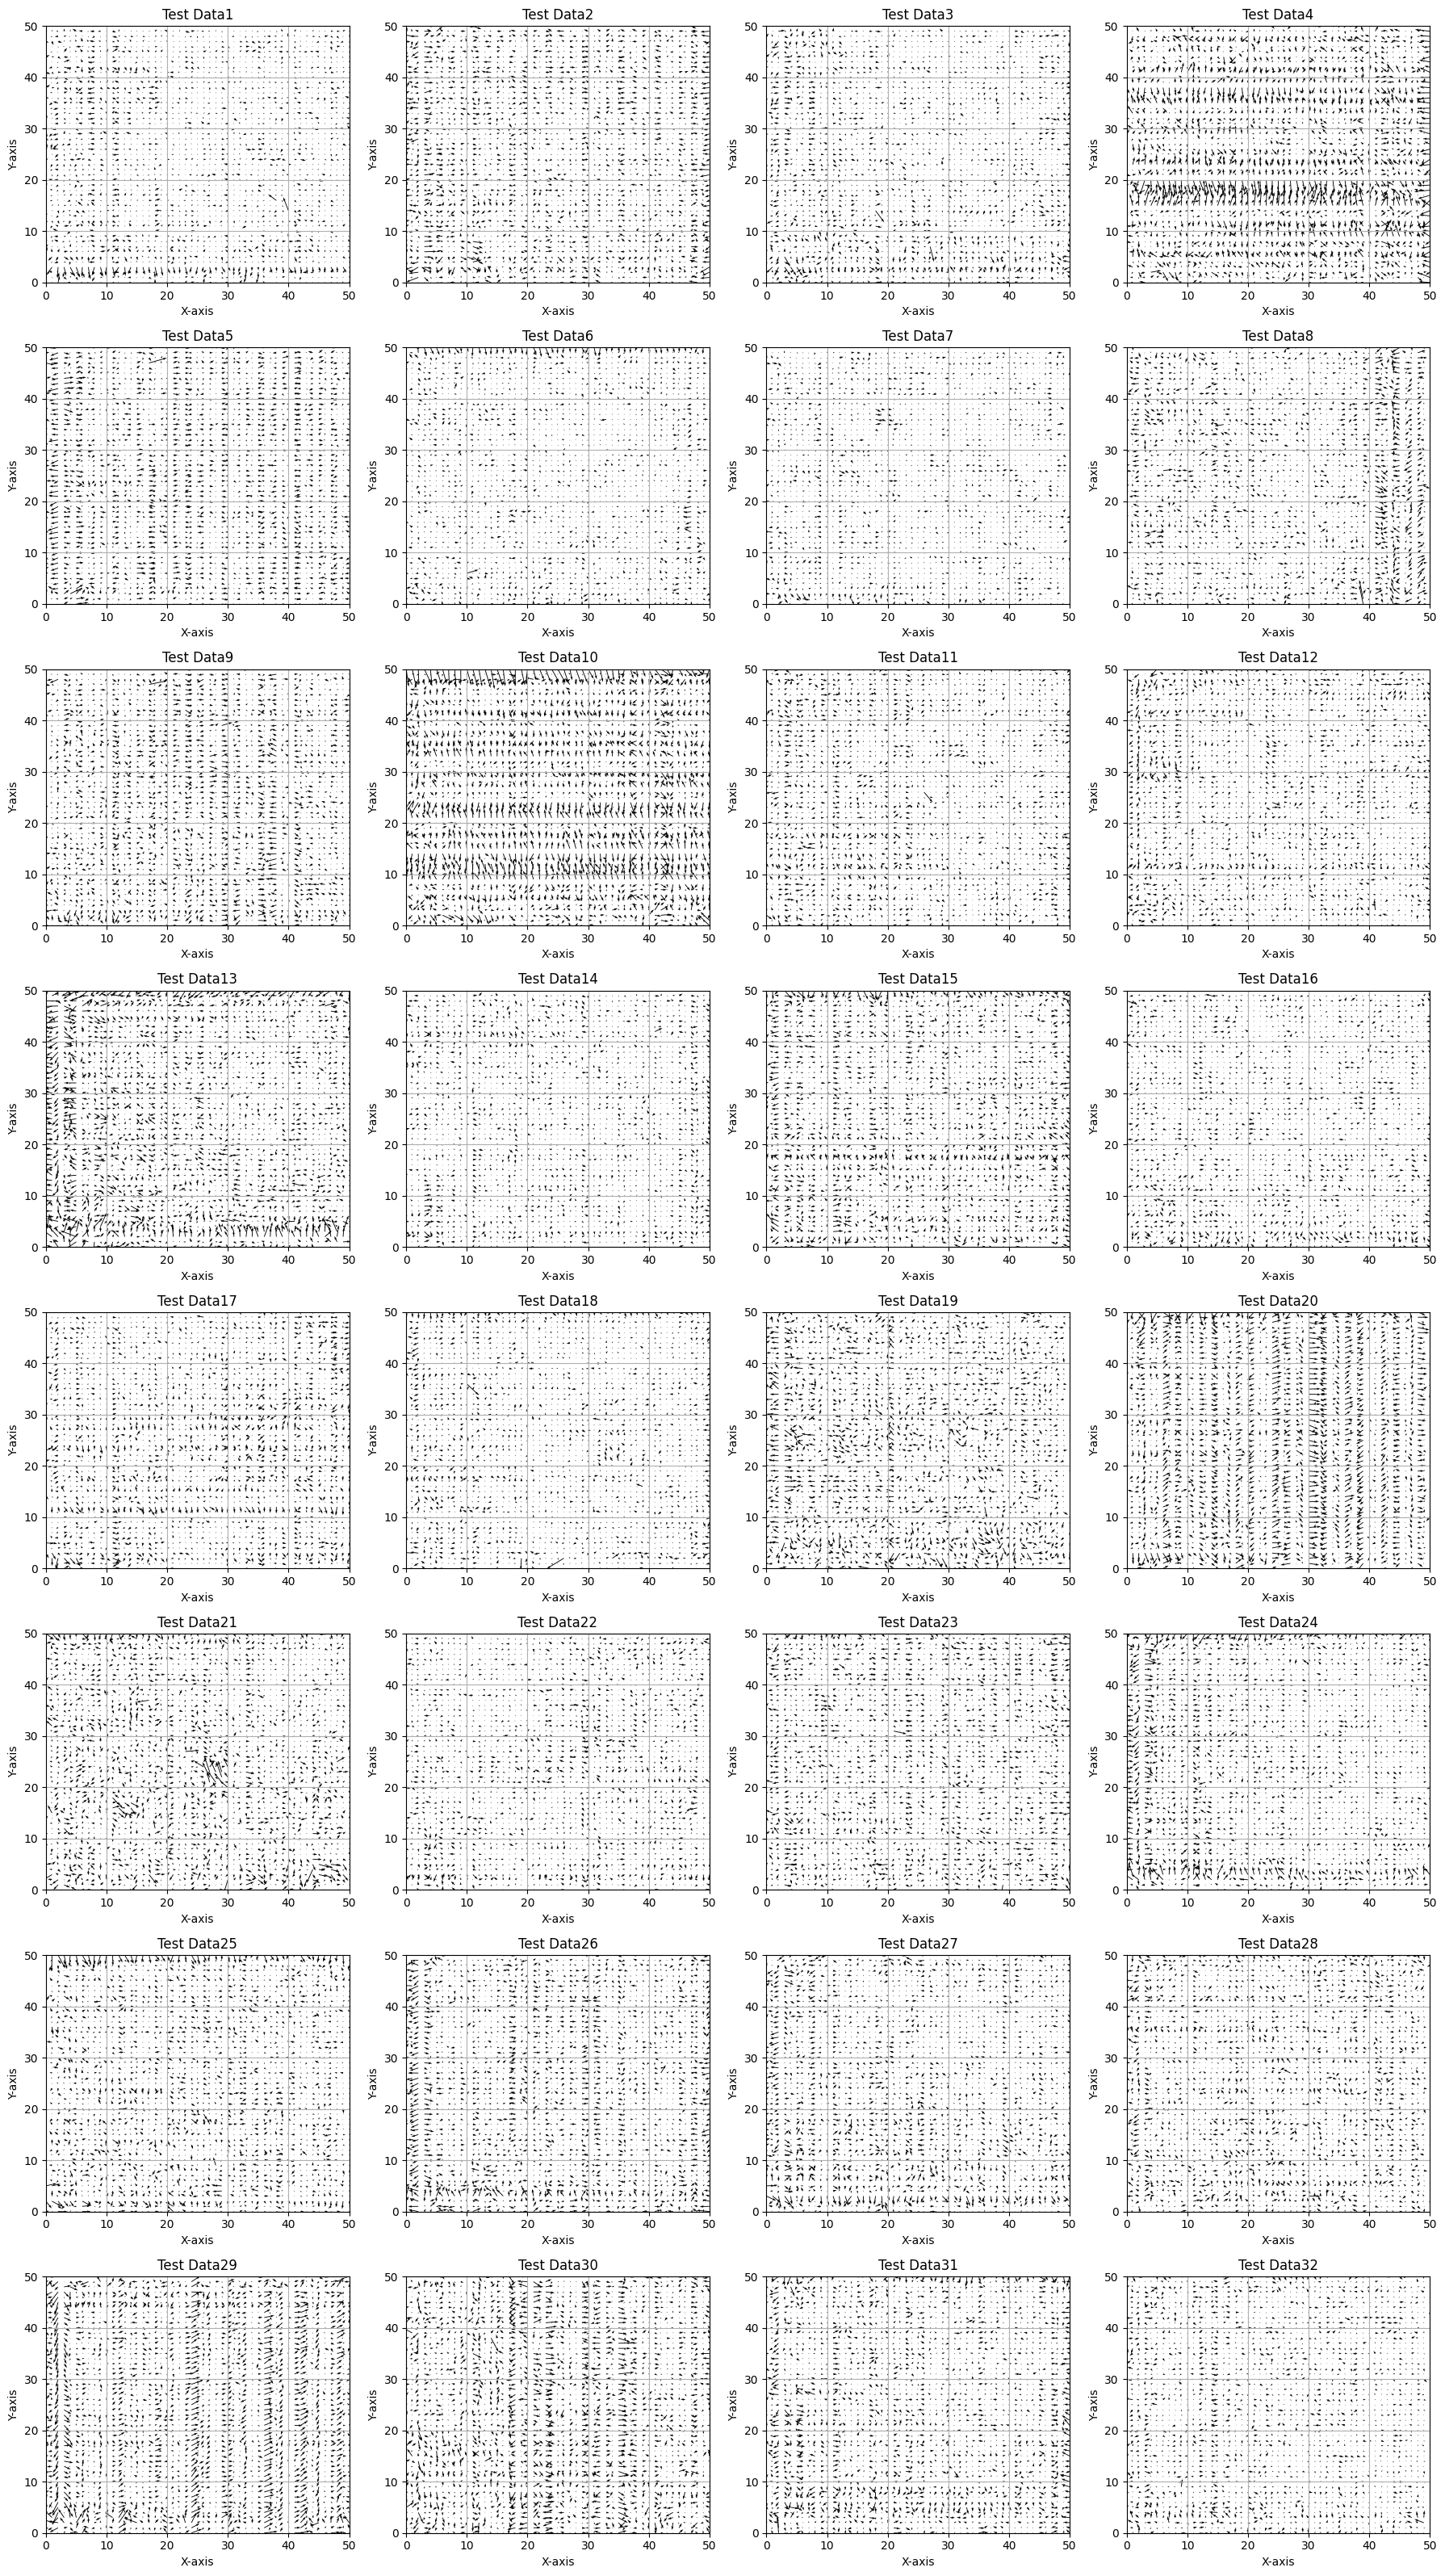

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(8, 4, figsize=(18, 32)) 

for i in range(32):

    high_res_tensor = tf.convert_to_tensor(original_hr[i], dtype=tf.float32)
    predicted_tensor = tf.convert_to_tensor(predicted[i], dtype=tf.float32)
    
    # org_test_hr=high_res_tensor* (max_num - min_num) + min_num
    # org_predicted_image=predicted_tensor* (max_num - min_num) + min_num

     # min_num과 max_num 정의
    min_num = read_sst_file(test_dir[i]).min()
    max_num = read_sst_file(test_dir[i]).max()
    # 스케일링 복원
    org_test_hr = high_res_tensor * (max_num - min_num) + min_num
    org_predicted_image = predicted_tensor * (max_num - min_num) + min_num

    
    # 각 벡터들의 시작점 x, y 좌표
    y_coords, x_coords = np.mgrid[0:51, 0:51] # y_coords와 x_coords를 순서대로 생성

    # 벡터의 방향과 크기
    u_values = (org_test_hr[:, :, 0] - org_predicted_image[:, :, 0])
    v_values = (org_test_hr[:, :, 1] - org_predicted_image[:, :, 1])
    
    axs[i//4][i%4].quiver(x_coords, y_coords, u_values, v_values,  scale=3, scale_units='xy', angles='xy')
    
    # 축 범위 설정
    axs[i//4][i%4].set_xlim(np.min(x_coords), np.max(x_coords))
    axs[i//4][i%4].set_ylim(np.min(y_coords), np.max(y_coords))

    # 그래프 타이틀 및 축 레이블 설정
    axs[i//4][i%4].set_title(f'Test Data{i+1}')
    axs[i//4][i%4].set_xlabel('X-axis')
    axs[i//4][i%4].set_ylabel('Y-axis')

    # 벡터의 축을 맞추기 위해 가로 세로 비율 설정
#     axs[i//2][i%2].set_aspect('equal', adjustable='box')

    # 그리드 추가
    axs[i//4][i%4].grid(True)
    
# 그래프 레이아웃 조정
plt.tight_layout()

# 그래프 출력
plt.show()
